In [47]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline 
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [19]:
spark = SparkSession.builder.appName("a5").getOrCreate()
csv_file = "gs://dataproc-staging-us-central1-823943063357-inh6zdl6/data/light_spotify_dataset.csv"
df = spark.read.csv(csv_file, 
                    header=True,
                    inferSchema=True)
df.select("Genre", 
          "Key", 
          "Tempo", 
          "Loudness", 
          "Energy", 
          "Danceability", 
          "Positiveness", 
          "Speechiness", 
          "Liveness", 
          "Acousticness", 
          "Instrumentalness").show(10)

+-----+------+-----+--------+------+------------+------------+-----------+--------+------------+----------------+
|Genre|   Key|Tempo|Loudness|Energy|Danceability|Positiveness|Speechiness|Liveness|Acousticness|Instrumentalness|
+-----+------+-----+--------+------+------------+------------+-----------+--------+------------+----------------+
|  pop| F Maj|  128|    -6.0|    78|          56|          60|          3|      31|           7|               0|
|  pop|A# Maj|  102|  -10.72|    36|          52|          38|          2|       7|          68|               0|
|  pop| E Maj|  139|    -5.7|    78|          85|          97|          3|       8|          20|               2|
|  pop| F Maj|  132|    -3.0|    76|          50|          89|          3|      32|           3|               0|
|  pop| F Maj|  132|    -3.0|    76|          50|          89|          3|      32|           3|               0|
|  pop| C Maj|  135|    -7.0|    92|          40|          43|          4|      31|     

In [30]:
# Input features
input_cols = ["Tempo", 
               "Loudness",
               "Energy", 
               "Danceability", 
               "Positiveness", 
               "Speechiness", 
               "Liveness", 
               "Acousticness", 
               "Instrumentalness"]
# Prediction
target_col = "Genre"

s_df = df.select(input_cols + [target_col]).dropna()
s_df = s_df.withColumn("Tempo", col("Tempo").cast("double"))

indexer = StringIndexer(inputCol=target_col, outputCol='label', handleInvalid="keep")

In [31]:
trainDF, testDF = s_df.randomSplit([0.8, 0.2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set""")

There are 189581 rows in the training set, and 47405 in the test set


In [38]:
vecAssembler = VectorAssembler(handleInvalid="skip", inputCols=input_cols, outputCol='features')

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[indexer, vecAssembler, dt])
model = pipeline.fit(trainDF)
predictions = model.transform(testDF)

25/05/11 08:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB


In [39]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy of Decision Tree Classification: {accuracy:.4f}")

Test Accuracy of Decision Tree Classification: 0.3081


In [40]:
# Extract how important each feature is
f_importance = model.stages[-1].featureImportances
importance_val = f_importance.toArray().tolist()
importanceDF = pd.DataFrame({'Feature': input_cols,
                             'Importance': importance_val})
importanceDF = importanceDF.sort_values(by='Importance', ascending=False)
print(importanceDF)

            Feature  Importance
5       Speechiness    0.621972
7      Acousticness    0.148752
2            Energy    0.106387
3      Danceability    0.091557
4      Positiveness    0.031332
0             Tempo    0.000000
1          Loudness    0.000000
6          Liveness    0.000000
8  Instrumentalness    0.000000


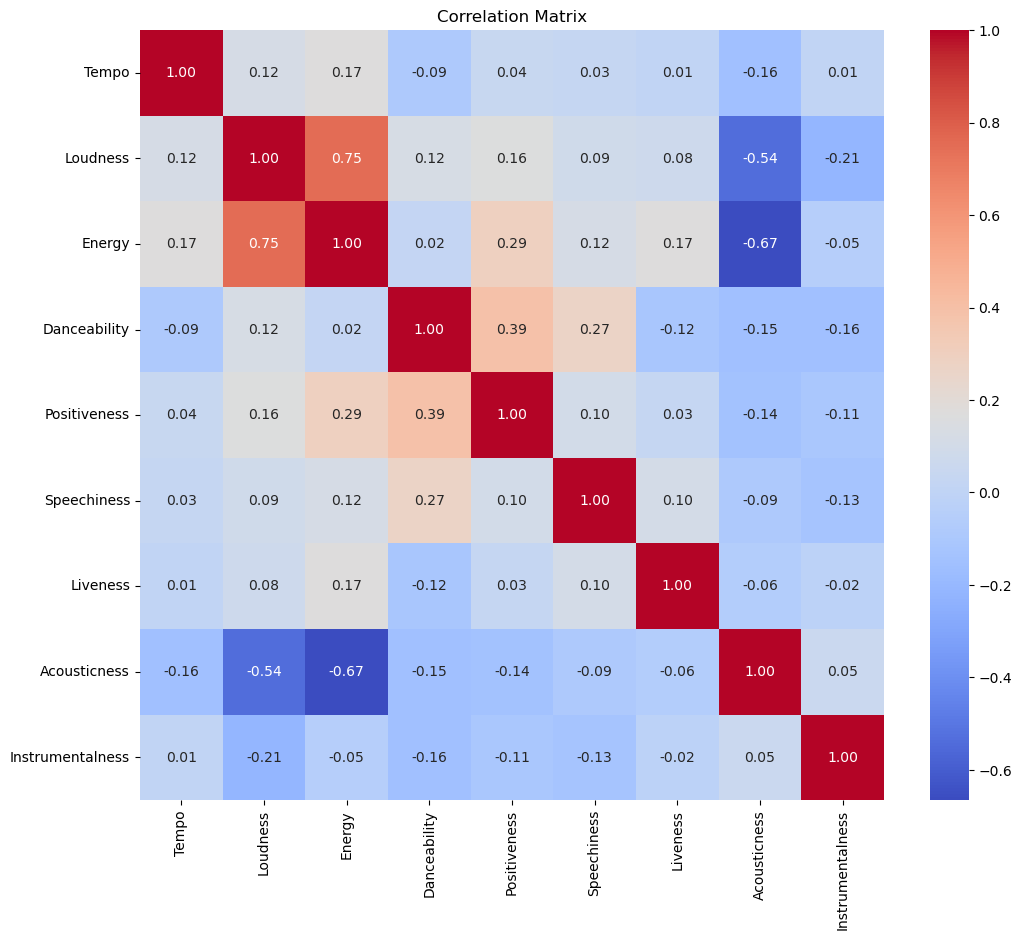

In [48]:
# Correlation Matrix Plot
features_pd = s_df.select(input_cols).toPandas()
correlation = features_pd.corr()

plt.figure(figsize=(12,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

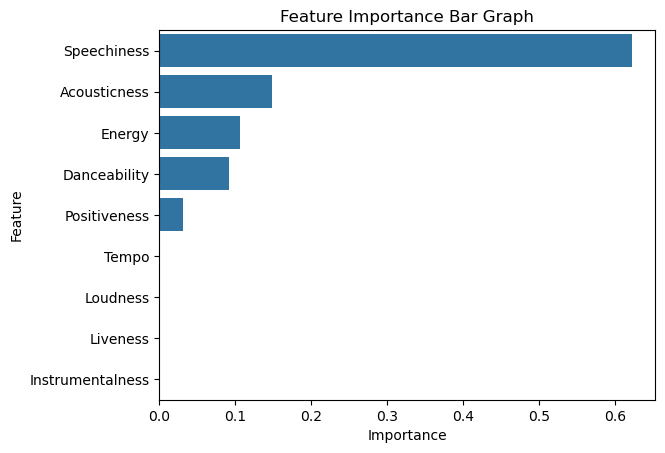

In [49]:
# Bar Plot for feature importance
sns.barplot(x='Importance', y='Feature', data=importanceDF)
plt.title("Feature Importance Bar Graph")
plt.show()